In [1]:
import numpy as np
import pandas as pd
from itertools import product
#from nltk import ngrams
#import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Calculate n grams

In [46]:
alphabet = 'абвгдеёжзийклмнопрстуфхцчьыъшщэюя'
n = 1

def build_n_grams(n):
    combinations = [''.join(val) for val in [p for p in product(list(alphabet),repeat = n)]]
    return combinations

n_grams = build_n_grams(n)

# Read textes and build dataframe

In [47]:
def build_dataframe(text: str, gramms):
    text_data = {}
    for i in gramms:
        text_data[i] = text.count(i)
    return text_data

In [48]:
def read_text(filepath, n_grams):
    data = {}
    with open(filepath, 'r') as f:
        try:
            text = ''.join(filter(str.isalpha, f.read()))
            data['lenght'] = len(text)
            data.update(build_dataframe(text, n_grams))
        except UnicodeDecodeError as e: 
            print('Unable to read the text (some encoding errors)')
            print('\033[91m {} \033[0m'.format(str(e)))
    return data

In [49]:
def read_authors(dirname, n_grams):
    data = []
    for _dir in os.listdir(dirname):
        _current_dir = os.path.join(dirname,_dir)
        if(os.path.isdir(_current_dir)):
            for _file in os.listdir(_current_dir):
                if '.DS_Store' in _file:
                    print('\033[91m {} \033[0m'.format(str('.DS_Store file')))
                else:
                    filepath = os.path.join(_current_dir, _file)
                    text = None
                    string_data = {'author': _dir, 'name': _file}
                    string_data.update(read_text(filepath, n_grams))
                    data.append(string_data)
    return data

# Read data for prediction 

In [50]:
def read_unknown(path, n_grams):
    data = {}
    for _file in os.listdir(path):
        if '.DS_Store' in _file:
            print('\033[91m {} \033[0m'.format(str('.DS_Store file')))
        else:
            data[_file] = [read_text(os.path.join(path, _file), n_grams)]
    return data

# Modify data and calculate PDF

In [51]:
data = read_authors('./5', n_grams)
df = pd.DataFrame(data)
unique_authors = df.author.unique()

 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 


In [52]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,author,lenght,name,а,б,в,г,д,е,ж,...,ч,ш,щ,ъ,ы,ь,э,ю,я,ё
0,Марк Фрост,4121,Фрост. Альянс 1,307,60,171,72,109,363,47,...,68,31,18,2,80,82,7,23,71,0
1,Хаксли,4288,Хаксли гений и богиня 22,312,95,160,69,125,409,52,...,72,42,21,2,89,104,22,32,103,0
2,Казанцев,4288,Казанцев Бандитский доктор 3,304,78,216,71,123,361,43,...,30,39,14,1,94,69,8,28,82,0
3,Генри Миллер,4172,Генри Миллиер. Время убийц 9,290,88,186,61,131,377,29,...,64,25,24,0,103,73,10,28,116,1
4,Курпатов,4214,Курпатов любовь и измена 9,326,76,203,69,97,418,70,...,95,22,13,0,67,89,26,37,73,0


In [53]:
#Unique authors list
unique_authors

array(['Хаксли', 'Ильин', 'Калинина', 'Курпатов', 'Агапкин', 'Марк Фрост',
       'Достоевский', 'Тургенев', 'Генри Миллер', 'Александрова',
       'Казанцев'], dtype=object)

In [54]:
#Dense probabulity for all combinations
def dense_probability(text_frame):
    return text_frame.div(text_frame.lenght, axis=0)

def calc_ethalon(author, data_frame):
    _df = data_frame.loc[data_frame.author == author].drop(['author', 'name'], axis=1).sum()
    return dense_probability(_df)

In [55]:
#Calculate distance between text and the ethalon. We need only letters combinations to pass the function arguments
def dist_between_text_ethalon(text, ethalon):
    dist = np.sum(np.absolute(np.array(text - ethalon)))
    return dist
#Calculate the deviation of the own textes from pseudo ethalon. Own text is excluded form the ethalon
def deviation_own(author, data_frame):
    distances = []
    current_text = None
    ethalon_without_current = None
    data_frame = data_frame.loc[data_frame.author == author].drop(['author', 'name'], axis=1)
    for i in data_frame.index:
        current_text = dense_probability(data_frame.loc[[i]])
        ethalon_without_current = dense_probability(data_frame.drop([i], axis=0).sum())
        distances.append(dist_between_text_ethalon(current_text, ethalon_without_current))
    return distances
#Calculate the deviation of the foreign textes from ethalon
def deviation_foreign(author, ethalon, data_frame):
    distances = []
    current_text = None
    data_frame = data_frame.loc[data_frame.author != author].drop(['author', 'name'], axis=1)
    for i in data_frame.index:
        current_text = dense_probability(data_frame.loc[[i]])
        distances.append(dist_between_text_ethalon(current_text, ethalon))
    return distances

In [56]:
#Calculate author ethalon
authors_e = {}
authors_deviation = {}
for author in unique_authors:
    authors_e[author] = calc_ethalon(author, df)
    authors_deviation[author] = {'own' : min(deviation_own(author, df)), 'foreign' : max(deviation_foreign(author, authors_e[author], df))}

In [57]:
#author textes diviation from ethalon
authors_deviation

{'Хаксли': {'own': 0.05297824652812294, 'foreign': 0.19982916677128687},
 'Ильин': {'own': 0.05856777831166668, 'foreign': 0.20516003623873497},
 'Калинина': {'own': 0.05738597135194808, 'foreign': 0.22760629584400588},
 'Курпатов': {'own': 0.059516747228423844, 'foreign': 0.21726638798232625},
 'Агапкин': {'own': 0.0674324789100204, 'foreign': 0.2131116113648844},
 'Марк Фрост': {'own': 0.048384698569954365, 'foreign': 0.21674275081088654},
 'Достоевский': {'own': 0.06745035836970117, 'foreign': 0.22514131935241002},
 'Тургенев': {'own': 0.06286393659225553, 'foreign': 0.2305776749738025},
 'Генри Миллер': {'own': 0.06189515903708895, 'foreign': 0.20467440965869804},
 'Александрова': {'own': 0.05503279933712743, 'foreign': 0.2116230045526754},
 'Казанцев': {'own': 0.05113531447999586, 'foreign': 0.2039046168155804}}

In [58]:
ro_div = 1
argmin = 0
argmax = 10
for i in authors_deviation:
    if authors_deviation[i]['own'] > argmin:
        argmin = authors_deviation[i]['own']
    if authors_deviation[i]['foreign'] < argmax:
        argmax = authors_deviation[i]['foreign']
ro_div = (argmin+argmax)/2

In [59]:
#distance to divide authors
ro_div

0.13363976257049404

# Authors prediction

In [60]:
predict = read_unknown('./predict5', n_grams)

 .DS_Store file 


In [61]:
def text_distances(text, ethalons):
    dist = 1
    data_dist = {}
    for author in ethalons:
        dist = dist_between_text_ethalon(authors_e[author],dense_probability(text))
        data_dist[author] = dist
    return data_dist
def predict_text(text, ethalons, max_dist_own = 1, min_dist_foreign = 1):
    distances = text_distances(text, ethalons)
    author_min = min(distances, key = lambda x: distances.get(x))
    author = author_min if distances[author_min] < ro_div else 'unknown'
    return author
        

In [62]:
predictions = {}
for i in predict:
    predictions[i] = predict_text(pd.DataFrame(predict[i]),authors_e)

In [63]:
#prediction for unknown authors
predictions

{'Фрост. Альянс 3': 'Марк Фрост',
 'Генри Миллиер. Время убийц 8': 'Генри Миллер',
 'Александрова китайская кукла 3': 'Александрова',
 'Калинина Узор твоих снов 13': 'Калинина',
 'Хаксли гений и богиня 20': 'Достоевский',
 'Генри Миллер. Время убийц 13': 'Генри Миллер',
 'Хаксли Одивный новый мир 16': 'Тургенев',
 'Ильин Господа офицеры 10': 'Ильин',
 'Достоевский. Повесть. Хозяйка. часть 3': 'Тургенев',
 'Ильин Господа офицеры 26': 'Ильин',
 'Фрост Пробуждение 14': 'Марк Фрост',
 'Ильин Господа офицеры 18': 'Марк Фрост',
 'Курпатов проблемный ребенок 7': 'Курпатов',
 'Идиот 1': 'Достоевский',
 'Тургенев Первая любовь 2': 'Марк Фрост',
 'Тургенев Дворянское гнездо 3': 'Тургенев',
 'Господин прохарчин 6': 'Тургенев',
 'все о женских гормонах 5': 'Агапкин',
 'Генри Миллер. тропик рака 6': 'Генри Миллер',
 'Калинина Седьмой мост 18': 'Александрова',
 'Двойник 3': 'Достоевский',
 'Александрова ад да винчи 13': 'Александрова',
 'Хаксли Остров 2': 'Казанцев',
 'Александрова меч

# Graphics for the first method

In [68]:
def build_data_for_drawing(authors_deviation):
    average_distributions_own = []
    average_distributions_foreign = []
    for dev in authors_deviation:
        average_distributions_own.extend(deviation_own(dev, df))
        average_distributions_foreign.extend(deviation_foreign(dev,authors_e[dev], df))
    x_data_own = np.linspace(min(average_distributions_own), max(average_distributions_own), 10)
    y_data_own = np.zeros(10)
    for i in average_distributions_own:
        y_data_own[np.searchsorted(x_data_own, i)] += 1
    y_data_own = y_data_own/len(average_distributions_own)
    
    x_data_foreign = np.linspace(min(average_distributions_foreign), max(average_distributions_foreign), 10)
    y_data_foreign = np.zeros(10)
    for i in average_distributions_foreign:
        y_data_foreign[np.searchsorted(x_data_foreign, i)] += 1
    y_data_foreign = y_data_foreign/len(average_distributions_foreign)
    
    plt.plot(x_data_own, y_data_own, label="Власний текст")
    plt.plot(x_data_foreign, y_data_foreign, label="Чужий текст")
    plt.xlabel("Відстань до еталону")
    plt.ylabel("Ймовірність")
    plt.title("Тексти довжиною 5 000 (монограми)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


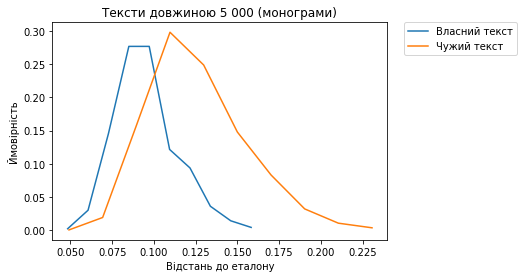

In [69]:
build_data_for_drawing(authors_deviation)

In [66]:
def build_stat_data(data):
    length = len(data)
    probability = 0
    for key in data.keys():
        if predictions[key].lower() in key.lower():
            probability += 1
    return probability/length

In [67]:
#probability for this method
build_stat_data(predictions)

0.38202247191011235

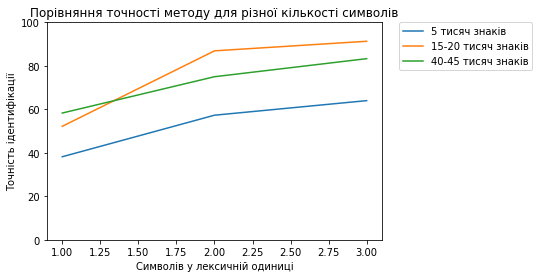

In [70]:
#probability graph
data_pdf_x = [1,2,3]
data_proba_y = [[38.2, 57.3, 64], [52.2, 86.9, 91.3], [58.3, 75, 83.3]]

plt.plot(data_pdf_x, data_proba_y[0], label="5 тисяч знаків")
plt.plot(data_pdf_x, data_proba_y[1], label="15-20 тисяч знаків")
plt.plot(data_pdf_x, data_proba_y[2], label="40-45 тисяч знаків")
plt.ylim(0,100)
plt.ylabel("Точність ідентифікації")
plt.xlabel("Символів у лексичній одиниці")
plt.title("Порівняння точності методу для різної кількості символів")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

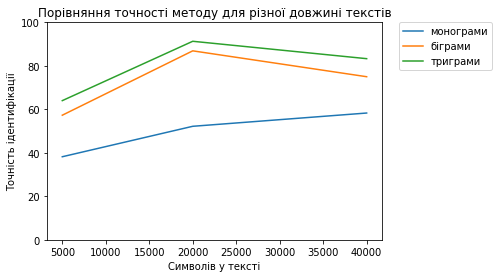

In [71]:
#probability graph
data_proba_x = [5000, 20000, 40000]
data_probe_pdf_y = np.array(data_proba_y).transpose()

plt.plot(data_proba_x, data_probe_pdf_y[0], label="монограми")
plt.plot(data_proba_x, data_probe_pdf_y[1], label="біграми")
plt.plot(data_proba_x, data_probe_pdf_y[2], label="триграми")
plt.ylim(0,100)
plt.ylabel("Точність ідентифікації")
plt.xlabel("Символів у тексті")
plt.title("Порівняння точності методу для різної довжині текстів")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()